## Assignment 2, PROBLEM 1


## Random variable generation and transformation

The purpose of this problem is to show that you can implement your own sampler, this will be built in the following three steps:

1. [2p] Implement a Linear Congruential Generator where you tested out a good combination (a large $M$ with $a,b$ satisfying the Hull-Dobell (Thm 6.8)) of parameters. Follow the instructions in the code block.
2. [2p] Using a generator construct random numbers from the uniform $[0,1]$ distribution.
3. [4p] Using a uniform $[0,1]$ random generator, generate samples from 

$$p_0(x) = \frac{\pi}{2}|\sin(2\pi x)|, \quad x \in [0,1] \enspace .$$

Using the **Accept-Reject** sampler (**Algorithm 1** in TFDS notes) with sampling density given by the uniform $[0,1]$ distribution.

## 1)

**Implement a Linear Congruential Generator where you tested out a good combination (a large $M$ with $a,b$ satisfying the Hull-Dobell (Thm 6.8)) of parameters. Follow the instructions in the code block.**

To make a LCG we need:

- a modulus $m$ ($m > 0$)
- an integer multiplier $a$ ($0 \le a < m$)
- an integer increment $c$ ($0 \le c < m$)
- an integer seed $x_0$ ($0 \le x_0 < m$)
- an integer sequence length $n$

Using these inputs, the LCG generates numbers $x_1, x_2, \ldots x_{n-1} $ where $x_{i+1}$ is calculated from $x_i$ as defined by the following recurrence relation:

$$x_{i+1} \gets mod \left(a x_i + c , m \right)$$

In [1]:
def problem1_LCG(size=None, seed = 0):
    m, a, c = 2147483648, 65539, 0
    x = seed
    arr = [x % m] # Start the list with x=x0
    for i in range(2, size+1, 1):
        x = (a*x+c)%m
        arr.append(x)
    return arr

## 2)

**Using a generator construct random numbers from the uniform $[0,1]$ distribution.**

We want an LCG with a **full period** of $m$ so that we can use it with any seed and not get stuck at fixed points or short periodic sequences. This is a minimal requirement for simulation purposes that we will employ such sequences for.  Is there anyway to know what makes a LCG with a full period?  

It turns out that an LCG will have a full period if and only if:

- $b$ and $m$ are relatively prime or coprime.  i.e. the **greatest common divisor (gcd)** of $b$ and $m$ is $1$; and
- $a-1$ is divisible by all **prime factors** of $m$; and
- $a-1$ is a multiple of 4 if $m$ is a multiple of 4.

To get a simple pseudo-random Uniform$(0,1)$ generator, we scale the linear congruential sequence over [0, 1].  We can do this by dividing each element by the largest number in the sequence (2147483648 in the case of `problem1_LCG`). 

In [2]:
def problem1_uniform(generator=problem1_LCG, period = 1, size=None, seed=0):
    lcg = generator(size, seed)
    arr =  [lcgs/period for lcgs in lcg]
    return arr 

#test = problem1_uniform(size=100, period=2147483648, seed=1)
#test

## 3)

**Using a uniform $[0,1]$ random generator, generate samples from** 

$$p_0(x) = \frac{\pi}{2}|\sin(2\pi x)|, \quad x \in [0,1] \enspace .$$

**Using the Accept-Reject sampler (Algorithm 1 in TFDS notes) with sampling density given by the uniform $[0,1]$ distribution.**

We implement the Accept-Reject Sampler from p.95 ITDS

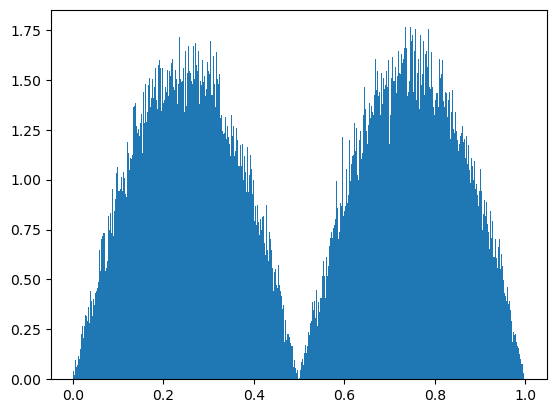

In [3]:
def problem1_accept_reject(uniformGenerator=None, n_iterations=None, seed=0):
    from numpy import sin, pi
    
    '''
    Double the size to get two uniform distributions. U should always be uniform, but
    here we are also using uniform as sampling density. In the algorithm, we see the 
    second half as U-sampling and the first half as the sampling density.
    '''
    init = uniformGenerator(period=2147483648, size=n_iterations*2,seed=seed)
    
    fx = lambda x : (pi/2)*abs(sin(x*2*pi))
    vals=[]
    
    for i in range(n_iterations):
        x = init[i] # Draw x from sampling density (first half)
        U = init[i+n_iterations] # Draw U from the second half, which is our U-sampling
        
        '''
        The scaling constant M is to be set such that f(x) ≤ Mg(x) for all x. 
        For the uniform distribution bounded by [0,1] we get the peculiar 
        situation that g(x) = uniform PDF = 1 / (1-0) = 1, 
        thus the scaling constant M = pi/2 satisfies the condition.
        '''
        r = 2*fx(x)/(pi) # Scale uniform distribution, m = pi/2
        
        if (U <= r):
            vals.append(x)
            
    return vals

test = problem1_accept_reject(problem1_uniform, n_iterations=100000, seed=1)

# Plot for vizualisation. Good for troubleshooting. Plot should look like the sampler function.
import matplotlib.pyplot as plt
plt.hist(test, density=True, bins=500)
plt.show()



## Markovian travel

The dataset `Travel Dataset - Datathon 2019` is a simulated dataset designed to mimic real corporate travel systems -- focusing on flights and hotels. The file is at `data/flights.csv`, i.e. you can use the path `data/flights.csv` from the notebook to access the file.

1. [2p] In the first code-box 
    1. Load the csv from file `data/flights.csv`
    2. Fill in the value of the variables as specified by their names.
2. [2p] In the second code-box your goal is to estimate a Markov chain transition matrix for the travels of these users. For example, if we enumerate the cities according to alphabetical order, the first city `'Aracaju (SE)'` would correspond to $0$. Each row of the file corresponds to one flight, i.e. it has a starting city and an ending city. We model this as a stationary Markov chain, i.e. each user's travel trajectory is a realization of the Markov chain, $X_t$. Here, $X_t$ is the current city the user is at, at step $t$, and $X_{t+1}$ is the city the user travels to at the next time step. This means that to each row in the file there is a corresponding pair $(X_{t},X_{t+1})$. The stationarity assumption gives that for all $t$ there is a transition density $p$ such that $P(X_{t+1} = y | X_t = x) = p(x,y)$ (for all $x,y$). The transition matrix should be `n_cities` x `n_citites` in size.
3. [2p] Use the transition matrix to compute out the stationary distribution.
4. [2p] Given that we start in 'Aracaju (SE)' what is the probability that after 3 steps we will be back in 'Aracaju (SE)'?

### 1)

1. Load the csv from file `data/flights.csv`
2. Fill in the value of the variables as specified by their names.

In [4]:
import csv 
data = []
with open('data/flights.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    data = [line for line in reader]

# Just regular data analysis
number_of_cities = len(set([entry[2] for entry in data])) #filter out duplicates
number_of_userCodes = 1339
number_of_observations = len(data)

### 2)
In the second code-box your goal is to estimate a Markov chain transition matrix for the travels of these users. For example, if we enumerate the cities according to alphabetical order, the first city `'Aracaju (SE)'` would correspond to $0$. Each row of the file corresponds to one flight, i.e. it has a starting city and an ending city. We model this as a stationary Markov chain, i.e. each user's travel trajectory is a realization of the Markov chain, $X_t$. Here, $X_t$ is the current city the user is at, at step $t$, and $X_{t+1}$ is the city the user travels to at the next time step. This means that to each row in the file there is a corresponding pair $(X_{t},X_{t+1})$. The stationarity assumption gives that for all $t$ there is a transition density $p$ such that $P(X_{t+1} = y | X_t = x) = p(x,y)$ (for all $x,y$). The transition matrix should be `n_cities` x `n_citites` in size.

We are given a function for creating a dictionary

In [5]:
# This is a very useful function that you can use for part 2. You have seen this before when parsing the
# pride and prejudice book.

def makeFreqDict(myDataList):
    '''Make a frequency mapping out of a list of data.

    Param myDataList, a list of data.
    Return a dictionary mapping each unique data value to its frequency count.'''

    freqDict = {} # start with an empty dictionary

    for res in myDataList:
        if res in freqDict: # the data value already exists as a key
                freqDict[res] = freqDict[res] + 1 # add 1 to the count using sage integers
        else: # the data value does not exist as a key value
            freqDict[res] = 1 # add a new key-value pair for this new data value, frequency 1

    return freqDict # return the dictionary created

In [6]:
import numpy as np

cities = [entry[2] for entry in data] 
unique_cities = sorted(set(cities)) # The unique cities 
n_cities = len(unique_cities) # The number of unique citites

'''The variables below were defined as XXX and they were to be filled in'''
# Count the different transitions
transitions = [(entry[2],entry[3]) for entry in data] # A list containing tuples ex: ('Aracaju (SE)','Rio de Janeiro (RJ)') of all transitions in the text
transition_counts = makeFreqDict(transitions) # A dictionary that counts the number of each transition 
# ex: ('Aracaju (SE)','Rio de Janeiro (RJ)'):4
indexToCity = {i:unique_cities[i] for i in range(n_cities)} # A dictionary that maps the n-1 number to the n:th unique_city,
# ex: 0:'Aracaju (SE)'
cityToIndex = {unique_cities[i]:i for i in range(n_cities)} # The inverse function of indexToWord, 
# ex: 'Aracaju (SE)':0

'''
Part 3, finding the maximum likelihood estimate of the transition matrix. 
The assignment was to define the transition_matrix variable, none of the
code was prewritten.
'''
# Quant matrix: Create a 2d array where each row represents a city.
# The values count how many transitions goes from the city to every other city
quant_matrix = []
for i in unique_cities:
    row = []
    for j in unique_cities:
        try:
            row.append(transition_counts[(i,j)])
        except:
            # No transitions happens when the city comes across itself. 
            # We append with zeros which will result in a zero diagonal in the matrix
            row.append(0)  
    quant_matrix.append(row)

npQuant = np.array(quant_matrix)
#print(npQuant) 

'''
Define the transition matrix. Sum every row and divide every row by its sum
to obtain the probabilities. Numpy division is carried out row-wise, so we 
have to transpose the matrix to get correct probabilities. Check correctness
by verifying that every row sums up to 1.
'''
transition_matrix = (npQuant/npQuant.sum(axis=0)).T
print(transition_matrix) 
#for i in transition_matrix:
    #print(sum(i))

# The transition matrix should be ordered in such a way that
# p_{'Aracaju (SE)','Rio de Janeiro (RJ)'} = transition_matrix[cityToIndex['Aracaju (SE)'],cityToIndex['Rio de Janeiro (RJ)']]
# and represents the probability of travelling Aracaju (SE)->Rio de Janeiro (RJ)

# Make sure that the transition_matrix does not contain np.nan from division by zero for instance

[[0.         0.12983559 0.14487965 0.23218891 0.1057651  0.13120567
  0.07570385 0.07839029 0.10203095]
 [0.15702265 0.         0.14675591 0.25273726 0.09704669 0.12417557
  0.06478443 0.06527178 0.09220572]
 [0.15520318 0.12999309 0.         0.23751007 0.1019627  0.12979164
  0.0695004  0.07252216 0.10351675]
 [0.15079296 0.1357189  0.14398869 0.         0.11705079 0.13275294
  0.10131375 0.10119162 0.11719036]
 [0.16544797 0.1255253  0.14889057 0.28193814 0.         0.12161708
  0.03992268 0.0389141  0.07774416]
 [0.16023622 0.1253937  0.14796588 0.24963911 0.09494751 0.
  0.06223753 0.06404199 0.09553806]
 [0.16758846 0.1185846  0.14362177 0.34534642 0.05649718 0.11281594
  0.         0.         0.05554564]
 [0.17060337 0.1174579  0.14733396 0.33910196 0.05413938 0.11412535
  0.         0.         0.05723807]
 [0.1607619  0.12012698 0.15225397 0.28431746 0.07830688 0.12325926
  0.03953439 0.04143915 0.        ]]


### 3)

**Use the transition matrix to compute out the stationary distribution.**

In [7]:
perron_eigenvector = np.abs(np.linalg.eig(transition_matrix.T)[1][:,0])
mu = perron_eigenvector/np.sum(perron_eigenvector)
stationary_distribution_problem2 = mu
stationary_distribution_problem2

array([0.13690932, 0.1132047 , 0.12780262, 0.21081107, 0.08752133,
       0.11210498, 0.06184532, 0.06290826, 0.0868924 ])

### 4)

**Given that we start in 'Aracaju (SE)' what is the probability that after 3 steps we will be back in 'Aracaju (SE)'?**

The transition matrix at `t=3` is the transition matrix raised to the third power `P3`. With this transition matrix, we can attain the probability for getting from state `a` to `b` by indexing `P3[a,b]`

In [8]:
P3 = np.linalg.matrix_power(transition_matrix,3)
return_probability_problem2 = P3[0,0]
print(return_probability_problem2)

0.13331717737273133


---
## Assignment 2, PROBLEM 3

**Derive the maximum likelihood estimate for $n$ IID samples from a random variable with the following probability density function:**
$$
f(x; \lambda) = \frac{1}{24} \lambda^5 x^4 \exp(-\lambda x), \qquad \text{ where, } \lambda>0, x > 0
$$

## Answer

1) Calculate the likelihood function
$$L(\lambda) = \prod_{i=1}^n f(x;\lambda) = \prod_{i=1}^n \frac{1}{24} \lambda^5 x_i^4 e^{-\lambda x_i} 
= \frac{1}{24^n} \lambda^{5n} x_i^4 \cdot \ldots \cdot x_n^4 \cdot e^{-\lambda \sum_{i=1}^n x_i} 
$$

2) Calculate the log-likelihood

$$
log L(\lambda) = \frac{1}{24^n} + 5nlog(\lambda) + \sum_{i=1}^n x_i^4 - \lambda \sum_{i=1}^n x_i
$$

$$
\frac{d}{d\lambda} log L(\lambda) = \frac{5n}{\lambda} - \sum_{i=1}^n x_i = 0 \Rightarrow \frac{5n}{\lambda} = \sum_{i=1}^n x_i
$$

$$\lambda = \frac{5n}{\sum_{i=1}^n x_i}$$

In [9]:
def MLeForAssignment2Problem3(x):
    return 5*len(x)/sum(x)

## Assignment 2, PROBLEM 4

Use the **Multi-dimensional Constrained Optimisation** example (in `07-Optimization.ipynb`) to numerically find the MLe for the mean and variance parameter based on `normallySimulatedDataSamples`, an array obtained by a specific simulation of $30$ IID samples from the $Normal(10,2)$ random variable.

Recall that $Normal(\mu, \sigma^2)$ RV has the probability density function given by:

$$
f(x ;\mu, \sigma) = \displaystyle\frac{1}{\sigma\sqrt{2\pi}}\exp\left(\frac{-1}{2\sigma^2}(x-\mu)^2\right)
$$

The two parameters, $\mu \in \mathbb{R} := (-\infty,\infty)$ and $\sigma \in (0,\infty)$, are sometimes referred to as the location and scale parameters.

You know that the log likelihood function for $n$ IID samples from a Normal RV with parameters $\mu$ and $\sigma$ simply follows from $\sum_{i=1}^n \log(f(x_i; \mu,\sigma))$, based on the IID assumption. 

NOTE: When setting bounding boxes for $\mu$ and $\sigma$ try to start with some guesses like $[-20,20]$ and $[0.1,5.0]$ and make it larger if the solution is at the boundary. Making the left bounding-point for $\sigma$ too close to $0.0$ will cause division by zero Warnings. Other numerical instabilities can happen in such iterative numerical solutions to the MLe. You need to be patient and learn by trial-and-error. You will see the mathematical theory in more details in a future course in scientific computing/optimisation. So don't worry too much now except learning to use it for our problems. 

## Answer

The crux of this exercise is to derive the negative log likelihood for the Gaussian distribution, which is the return value of the function to be defined. The rest is just about filling in the gaps in the prepared code, all of which follows from the examples in the optimization notebook.

\begin{align*}
- log f(x_1 \ldots x_n;\mu,\sigma) &= - log \left( \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{1}{2\sigma^2}(x_i-\mu)^2\right) \right) \\
&= -log \left( 2\pi\sigma^{-n/2} \exp\left(-\frac{1}{2\sigma^2}\sum_{i_1}^n(x_i-\mu)^2\right) \right) \\
&= -log \left( 2\pi\sigma^{-n/2} \right) - log \left( \exp\left(-\frac{1}{2\sigma^2}\sum_{i_1}^n(x_i-\mu)^2\right) \right) \\
&= -\frac{n}{2} \cdot -log \left( 2\pi\sigma^2 \right) +\frac{1}{2\sigma^2}\sum_{i_1}^n(x_i-\mu)^2 \\
&= \frac{n}{2}log \left( 2\pi\sigma^2 \right) + \frac{1}{2\sigma^2}\sum_{i_1}^n(x_i-\mu)^2
\end{align*}

We can implement this in code as:
$$\frac{1}{2} \sum_{i=1}^n log(2 \pi \sigma^2) + \frac{(x_i-\mu)^2}{\sigma^2}$$

In [10]:


import numpy as np
from scipy import optimize
# do NOT change the next three lines
np.random.seed(123456) # set seed
# simulate 30 IID samples drawn from Normal(10,2)RV
normallySimulatedDataSamples = np.random.normal(10,2,30) 

# define the negative log likelihoo function you want to minimise by editing XXX
def negLogLklOfIIDNormalSamples(parameters):
    '''return the -log(likelihood) of normallySimulatedDataSamples with mean and var parameters'''
    mu=parameters[0]
    sigma=parameters[1]
    return 0.5*np.sum(np.log(2*np.pi*sigma**2) + ((normallySimulatedDataSamples - mu)**2)/(sigma**2))

# you should only change XXX below and not anything else
parameter_bounding_box=((-20, 20), (0.1, 5.0)) # specify the constraints for each parameter - some guess work...
initial_arguments = np.array([0, 0]) # point in 2D to initialise the minimize algorithm
result_Ass2Prob4 = optimize.minimize(negLogLklOfIIDNormalSamples, initial_arguments, bounds=parameter_bounding_box) 
# call the minimize method above finally! you need to play a bit to get initial conditions and bounding box ok
result_Ass2Prob4


      fun: 58.63138728236711
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.10542677e-07, 7.10542740e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 93
      nit: 16
     njev: 31
   status: 0
  success: True
        x: array([9.26861961, 1.70820152])